In [409]:
import matplotlib
from matplotlib import pyplot as plt

plt.rc('font', family='serif', size = 10)
plt.rc('figure', figsize=(15,8))
# plt.rc('lines', linewidth=2)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', titlesize=32, labelsize=25) 
plt.rc('legend', fontsize=18) 
plt.rc('axes', titlepad=15, labelpad=15, grid=True, titleweight='normal', labelweight='normal')
plt.rc('grid', linestyle='dashed', linewidth=0.5)

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({
    "figure.facecolor":  "white",  # red   with alpha = 30%
    "axes.facecolor":    "white",  # green with alpha = 50%
})

In [410]:
import numpy as np

### The basic idea of extremum seeking is exposed here: http://flyingv.ucsd.edu/krstic/talks/talks-files/extremum-seeking-DISC12.pdf

In a couple words, extremum seeking is a closed-loop algorithm that injects a 0 average perturbation in a signal fed to a static map, uses the output to estimates the gradient of the map and steer the control toward correct direction to optimize the output value of the static map (in all the formulations here, we are trying to minimize)

Here we define a simple cost function trying to minimize the opposite of (production - runtime), assuming that the production will be simply linear with runtime until we empty the well and it simply saturates

In [411]:
def f(runtime, runtime_penalty=0.2):
    return - (np.minimum(2 * runtime, 1) - runtime_penalty * runtime)

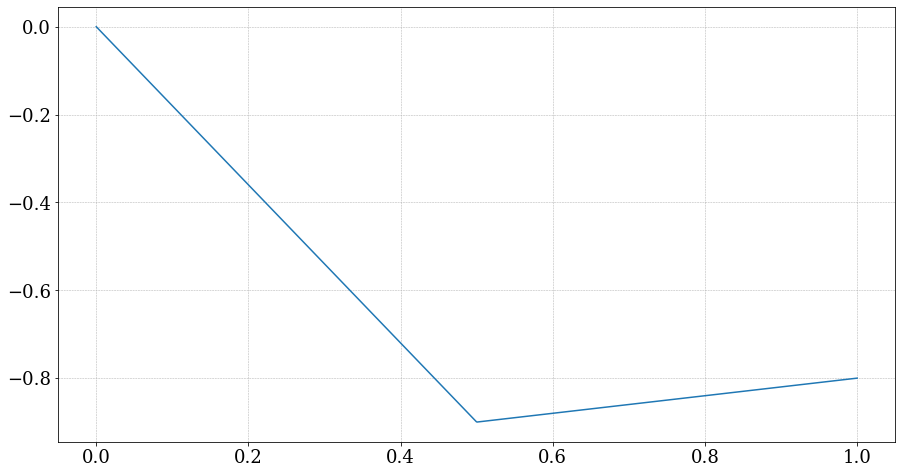

In [412]:
runtimes_to_plot = np.linspace(0, 1, 1000)

plt.plot(runtimes_to_plot, f(runtimes_to_plot))

The block diagram of extremum seeking is presented here

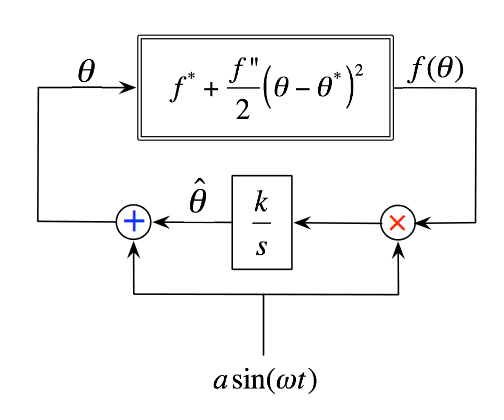

We are going to assume that the control is updated once a day (reasonnable because it will difficult to estimate the production over a shorter duration in practice)

In [413]:
# Values of the control loop parameters
a = 0.05
k = 2

# Pulsation of the perturbation, here we assume that the period of the excitation is two days
# Can't do less than that, we'd be in pure aliasing territory if the period is less than two sampling intervals
w = 2 * np.pi / 2

# Initial runtime value
runtime_0 = 0.3

# Number of days for the simulation
n = 100

# Defining the array of variables, runtimes correspond to theta and runtimes_est to theta_hat
runtimes = np.zeros(n)
runtimes[0] = runtime_0

runtimes_est = np.zeros(n)
runtimes_est[0] = runtime_0

demodulated_filts = np.zeros(n)
demodulated_filts[0] = 0

measurements = np.zeros(n)
measurements[0] = f(runtime_0)

# Cos instead of sinus, otherwise 2 days period leads to sinus always equal 0
def modulation_signal(i):
    return a * np.cos(w * i)

for i in range(1, n):    
    measurements[i] = f(runtimes[i-1]) + np.random.normal(loc=0.0, scale=0.1)
    
    # Demodulation
    demodulated = modulation_signal(i-1) * (measurements[i])
    
    # Filter demodulated signal
    demodulated_filts[i] = demodulated_filts[i-1] - 1 / 1 * (demodulated_filts[i-1] - demodulated)
    
    # Integrator
    runtimes_est[i] = runtimes_est[i-1] - k * demodulated_filts[i]
    
    # Injection of periodic excitation
    runtimes[i] = runtimes_est[i] + k * modulation_signal(i)

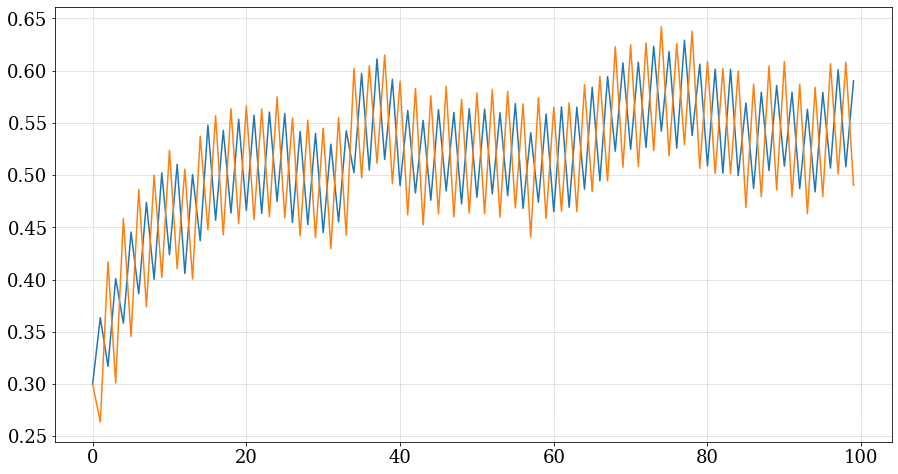

In [414]:
plt.plot(runtimes_est)
plt.plot(runtimes)

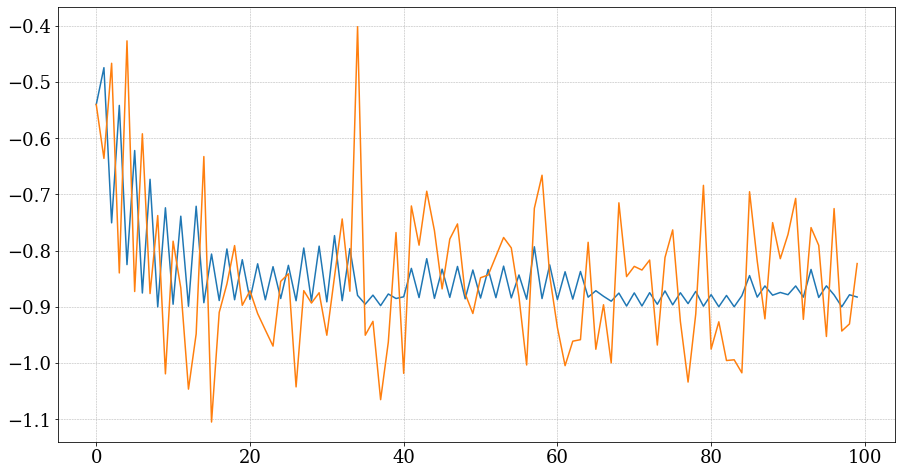

In [415]:
plt.plot(f(runtimes))
plt.plot(measurements)

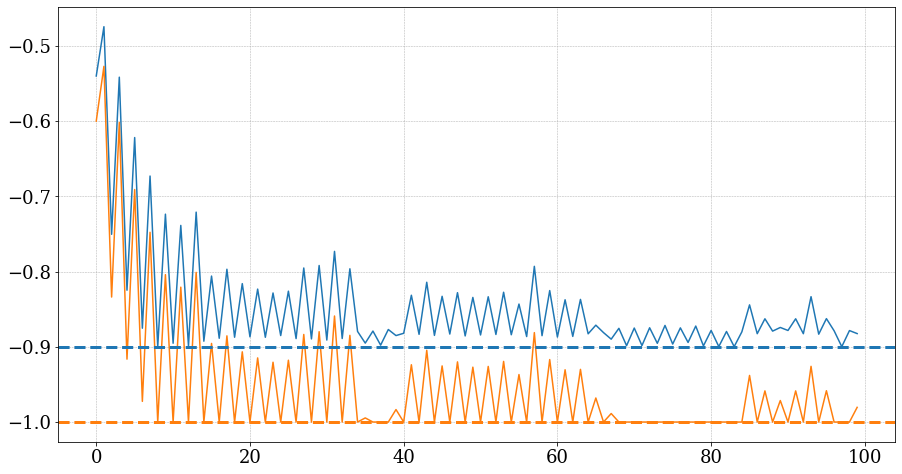

In [416]:
plt.plot(f(runtimes))
plt.plot(f(runtimes, runtime_penalty=0))
plt.axhline(y=np.min(f(runtimes_to_plot)), linestyle='--', linewidth=3, c=default_colors[0])
plt.axhline(y=np.min(f(runtimes_to_plot, runtime_penalty=0)), linestyle='--', linewidth=3, c=default_colors[1])

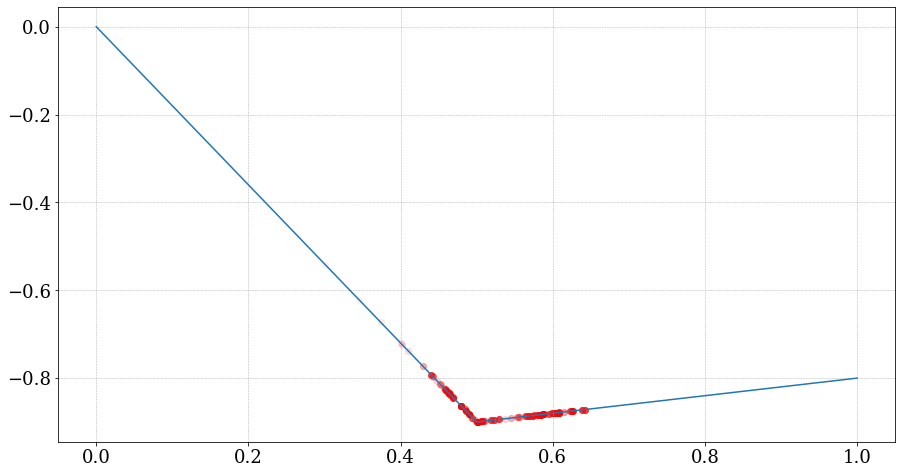

In [417]:
plt.plot(runtimes_to_plot, f(runtimes_to_plot))
for i in range(0, n):
    plt.scatter(runtimes[i], f(runtimes[i]), c='r', alpha=(1+i)/n)